In [3]:
import pandas as pd
from enum import Enum

df = pd.read_csv("../data/ngrams/ngrams_frequencies_withNames.csv")
df["Names"] = df["Names"].str.replace("Tasdi-final", "Tsadi-final")
df["Names"] = df["Names"].str.replace(r'Tsadi(?!-final)', "Tsadi-medial", regex=True)

class A(Enum):
    Alef = "Alef"
    Ayin = "Ayin"
    Bet = "Bet"
    Dalet = "Dalet"
    Gimel = "Gimel"
    He = "He"
    Het = "Het"
    Kaf = "Kaf"
    Kaf_final = "Kaf-final"
    Lamed = "Lamed"
    Mem = "Mem"
    Mem_medial = "Mem-medial"
    Nun_final = "Nun-final"
    Nun_medial = "Nun-medial"
    Pe = "Pe"
    Pe_final = "Pe-final"
    Qof = "Qof"
    Resh = "Resh"
    Samekh = "Samekh"
    Shin = "Shin"
    Taw = "Taw"
    Tet = "Tet"
    Tsadi_final = "Tsadi-final"
    Tsadi_medial = "Tsadi-medial"
    Waw = "Waw"
    Yod = "Yod"
    Zayin = "Zayin"
    Space = " "

str_to_enum = {
    e.value: e for e in A
}


enums = []

for names in df["Names"]:
    list_names = names.split("_")
    enums.append(tuple(str_to_enum[name] for name in list_names))


In [8]:
ls = [len(e) for e in enums]
df["ls"] = ls

(df["ls"] * (df["Frequencies"] / df["Frequencies"].sum())).sum()

np.float64(3.7426672477663985)

In [12]:
df["ls"].quantile(0.9)

np.float64(6.0)

In [13]:
import sys
sys.path.append("..")

from alphabet import load_alphabet
s = load_alphabet()

In [ ]:
ws = []
hs = []

for images in s.values():

    for image in images:
        h, w = image.shape
        ws.append(w)
        hs.append(h)

import numpy as np

np.mean(ws), np.mean(hs)


(np.float64(37.73451327433628), np.float64(47.579013906447535))

In [2]:
import pickle
import sys
sys.path.append("..")

import alphabet

with open("../data/bible.pickle", "rb") as f:
    encoded = pickle.load(f)

In [12]:
n_words = sum([len(x) for x in encoded])
n_words

97578

In [16]:
import numpy as np
np.empty((3, 2), dtype=object)[0][0]

In [18]:
encoded[0][-1]

<A.Space: ' '>

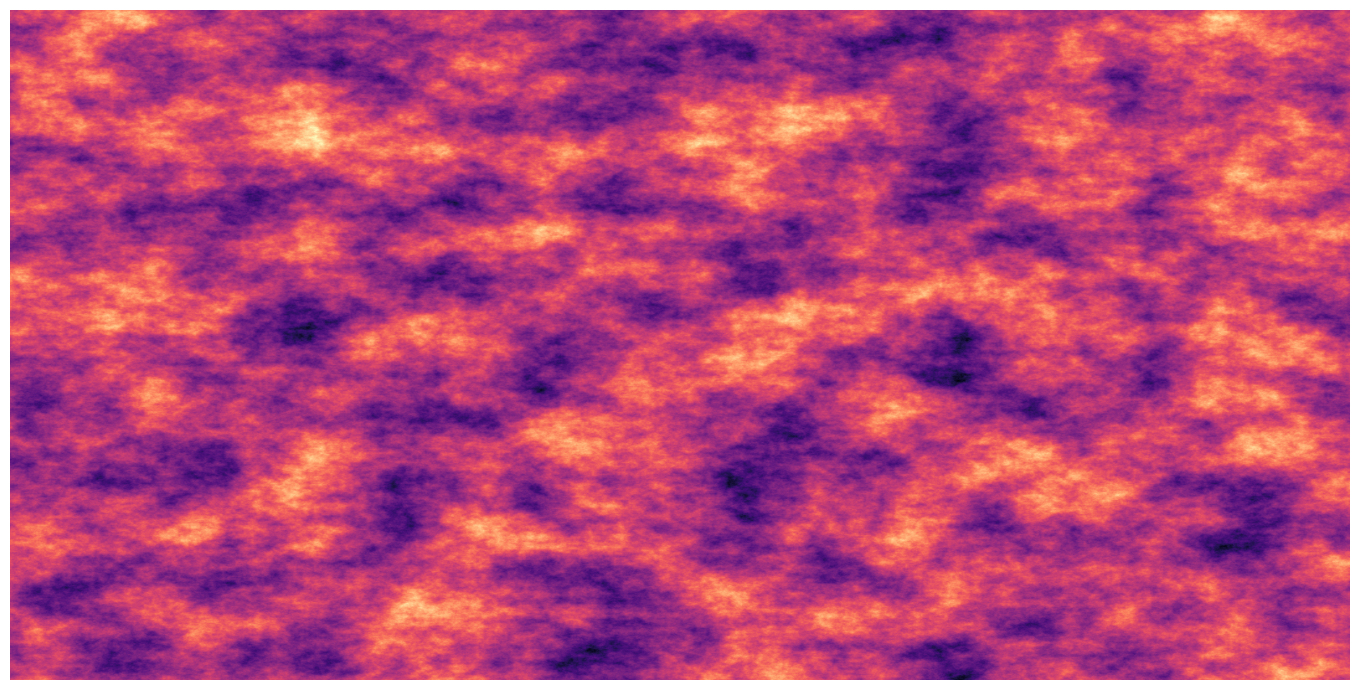

In [36]:
import PIL.Image
from noise import generate_perlin_noise_2d
import matplotlib.pyplot as plt
import PIL

h = 800
n = generate_perlin_noise_2d((h, h*2), (8, 8), octaves=8, persistence=0.7, lacunarity=2)


fig, ax = plt.subplots(figsize=(14, 7))
ax.set_axis_off()
ax.imshow(n, cmap='magma')
fig.tight_layout()
plt.show()
fig.savefig("./perlin.png")

In [39]:

from synthetic import DataGenerator
d = DataGenerator(max_sequence_length=200)

In [43]:
from noise import Noise

noise = Noise(d.settings.downscale_size)
noise.create_masks(4)

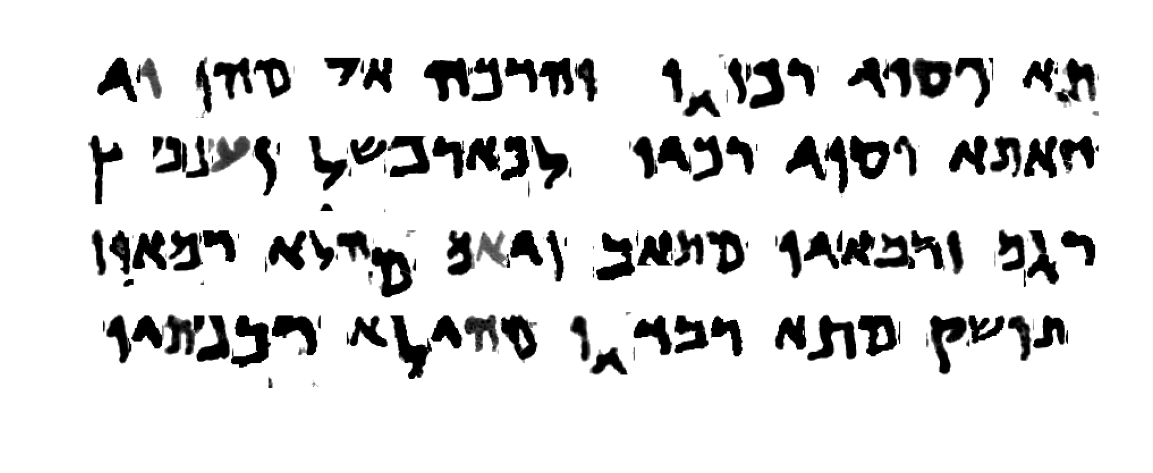

In [47]:
_, masks, scrolls = d.generate_passages_scrolls(1)


fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(scrolls[0], cmap="binary_r")
fig.tight_layout()
ax.axis('off')
plt.show()

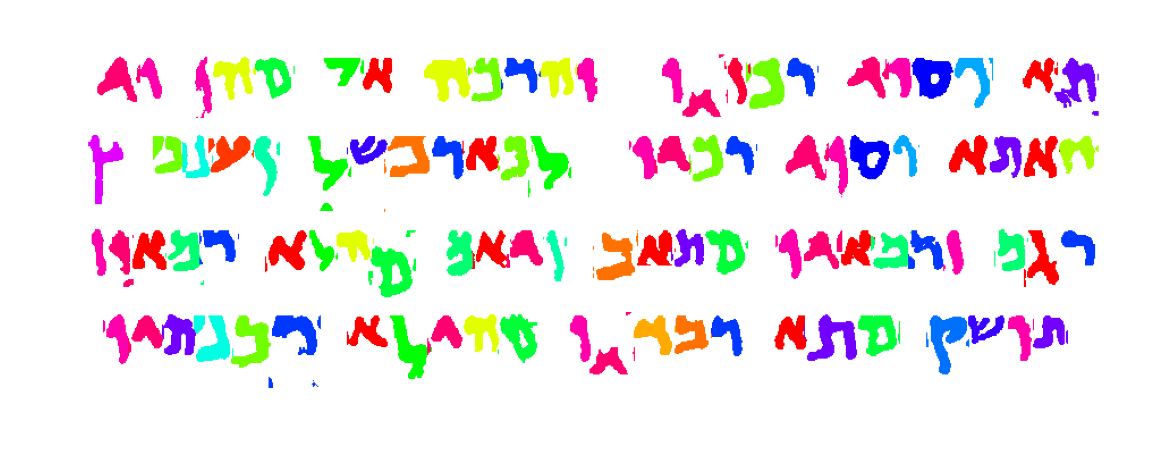

In [53]:
import cv2
import colorsys

segmentation = masks[0]
image = scrolls[0]
num_classes = segmentation.shape[0]
colors = [
    tuple(int(c * 255) for c in colorsys.hsv_to_rgb(i / num_classes, 1.0, 1.0))
    for i in range(num_classes)
]

overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for token, color in zip(range(num_classes), colors):
    mask = segmentation[token].astype(bool)
    for c in range(3):
        overlay[..., c][mask] = color[c]

blended = overlay

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(blended)
fig.tight_layout()
ax.axis('off')
plt.show()

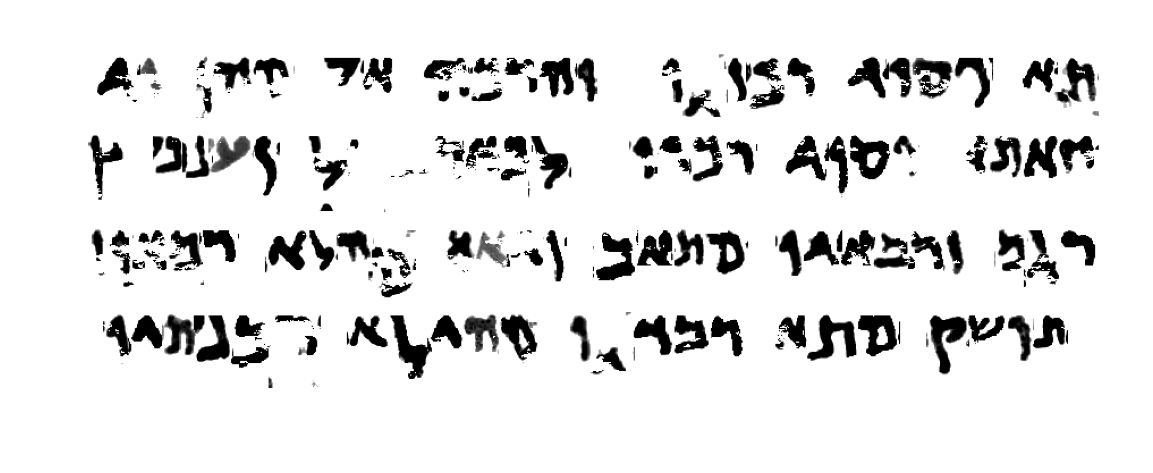

In [57]:
low_damage = noise.damage(scrolls, strength=0.2)
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(low_damage[0], cmap="binary_r")
fig.tight_layout()
ax.axis('off')
plt.show()

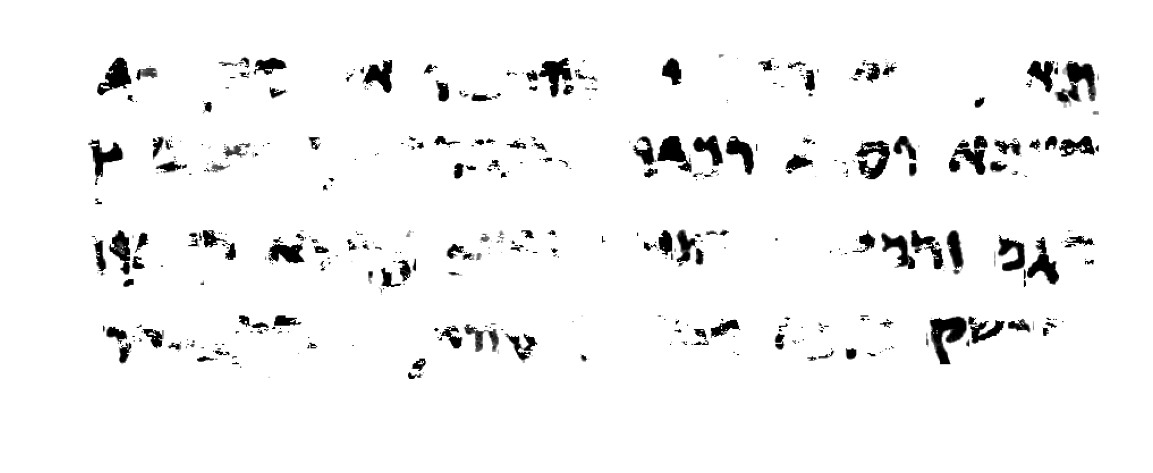

In [61]:
low_damage = noise.damage(scrolls, strength=0.33)
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(low_damage[0], cmap="binary_r")
fig.tight_layout()
ax.axis('off')
plt.show()

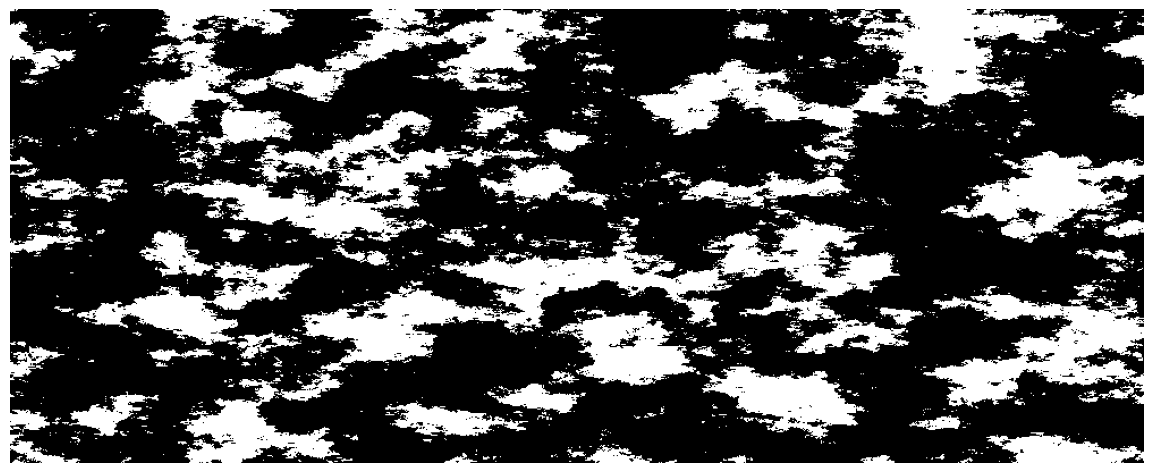

In [71]:
mask = noise.perlin[2] < -0.05

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(mask, cmap="binary_r")
fig.tight_layout()
ax.axis('off')
plt.show()


In [2]:
import sys
sys.path.append("..")
from alphabet import load_alphabet


a = load_alphabet(include_paths=True)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

modified = dict()

for char, images in a.items():

    example_shown = 0
    example_l = 0

    modified[char] = []

    for i_img, (img, path) in enumerate(images):

        name = path.name
        new_path = path.parent.parent.parent / "alphabet_cropped" / char / name

        modified[char].append([img, new_path])

        T = 5
        mask = img < 200
        height, _ = img.shape

        # The y coordinates of the "ink molecules"
        indices = np.where(mask)[0]
        cog = int(np.mean(indices))

        counts = np.sum(mask, axis=1)
        empty = counts < 2

        if empty[cog]:
            print(char, i_img + 1, height)
            fig, ax = plt.subplots()
            ax.imshow(img)
            ax.axhline(cog)

        assert not empty[cog]


        change = np.diff(empty)
        change_i = np.where(change)[0].tolist()

        change_i.append(height)
        if change_i[0] != 0:
            change_i.insert(0, 0)

        main_bounds_i = [None, None]
        i = 0
        for prev, fol in zip(change_i[:-1], change_i[1:], strict=True):

            if prev <= cog <= fol:
                main_bounds_i[0] = i
                main_bounds_i[1] = i + 1
                break

            i += 1


        assert main_bounds_i[0] is not None

        # Travel up
        l = main_bounds_i[0]
        cut_from_top = 0
        land = False
        while l > 0:

            if not land:
                distance = change_i[l] - change_i[l - 1]

                if distance > T:
                    cut_from_top = change_i[l] - 1
                    break

            l -= 1
            land = not land

        # Travel down
        t = main_bounds_i[1]
        maintain_top = height
        land = False
        while t < (len(change_i) - 1):

            if not land:
                distance = change_i[t + 1] - change_i[t]

                if distance > T:
                    maintain_top = change_i[t] + 2
                    break

            t += 1
            land = not land

        if cut_from_top > 0 or maintain_top < height:

            cropped = img[cut_from_top:maintain_top, :]
            modified[char][-1][0] = cropped

            if example_shown < example_l:

                fig, ax = plt.subplots(1, 2)
                ax[0].imshow(img)

                ax[1].imshow(cropped)

                fig.suptitle(char)

                example_shown += 1

        # p = counts / counts.sum()
        # y = np.arange(counts.size)
        # mean = np.sum(y * p)

        # plt.bar(y, counts)
        # plt.axvline(mean, color="red")



c:\Users\viktor\Documents\DeadSeaScrolls\viktor\..\data
c:\Users\viktor\Documents\DeadSeaScrolls\viktor\..\data
c:\Users\viktor\Documents\DeadSeaScrolls\viktor\..\data
c:\Users\viktor\Documents\DeadSeaScrolls\viktor\..\data
c:\Users\viktor\Documents\DeadSeaScrolls\viktor\..\data
c:\Users\viktor\Documents\DeadSeaScrolls\viktor\..\data
c:\Users\viktor\Documents\DeadSeaScrolls\viktor\..\data
c:\Users\viktor\Documents\DeadSeaScrolls\viktor\..\data
c:\Users\viktor\Documents\DeadSeaScrolls\viktor\..\data
c:\Users\viktor\Documents\DeadSeaScrolls\viktor\..\data
c:\Users\viktor\Documents\DeadSeaScrolls\viktor\..\data
c:\Users\viktor\Documents\DeadSeaScrolls\viktor\..\data
c:\Users\viktor\Documents\DeadSeaScrolls\viktor\..\data
c:\Users\viktor\Documents\DeadSeaScrolls\viktor\..\data
c:\Users\viktor\Documents\DeadSeaScrolls\viktor\..\data
c:\Users\viktor\Documents\DeadSeaScrolls\viktor\..\data
c:\Users\viktor\Documents\DeadSeaScrolls\viktor\..\data
c:\Users\viktor\Documents\DeadSeaScrolls\viktor\

In [50]:
import sys

sys.path.append("..")

from alphabet import load_alphabet


a = load_alphabet()

In [5]:
import numpy as np

ws = []
hs = []

for imgs in a.values():
    for img in imgs:
        h, w = img.shape
        ws.append(w)
        hs.append(h)

np.mean(ws), np.mean(hs)

(np.float64(37.72746974896153), np.float64(44.417735235687196))

In [4]:
import numpy as np

np.empty((10, 0))

array([], shape=(10, 0), dtype=float64)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

def cutout_noise(
        height: int,
        width: int,
        num_shapes: tuple[int, int] = (1, 4),
        radius: tuple[int, int] = (50, 150)
    ):
    mask = np.zeros((height, width))

    n_shapes = random.randint(num_shapes[0], num_shapes[1] - 1)

    heights = np.random.randint(0, height, n_shapes)
    widths = np.random.randint(0, width, n_shapes)
    angles = np.random.random(n_shapes) * 360
    axes = np.random.randint(radius[0], radius[1], (n_shapes, 2))

    for i in range(n_shapes):
        center = (widths[i], heights[i])
        axis = axes[i, :]
        angle = angles[i]
        cv2.ellipse(mask, center, axis, angle, 0, 360, color=1, thickness=-1)

    return mask > 0.5

In [131]:
np.array([2706, 3608]) / 3

array([ 902.        , 1202.66666667])

In [11]:
from importlib import reload
import sys
sys.path.append("..")

import noise
reload(noise)

import synthetic
reload(synthetic)

generator = synthetic.DataGenerator(
    settings=synthetic.SynthSettings(
        downscale_factor=0.5,
        margins=(80, 100),
        image_size=(676, 902),
        cutout_noise=True,
        cutout_noise_size=100,
        warp_noise=True
    )
)

tokens, seg, scrolls, lines = generator.generate_passages_scrolls(10, skip_char_seg=True)


In [ ]:
from time import sleep
import tqdm


for i in tqdm.tqdm(list(range(10)), position=1, leave=True):
    for _ in tqdm.tqdm(list(range(10)), position=0):
        sleep(0.03)

100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


In [ ]:
{0}
{i for i in range(5)}

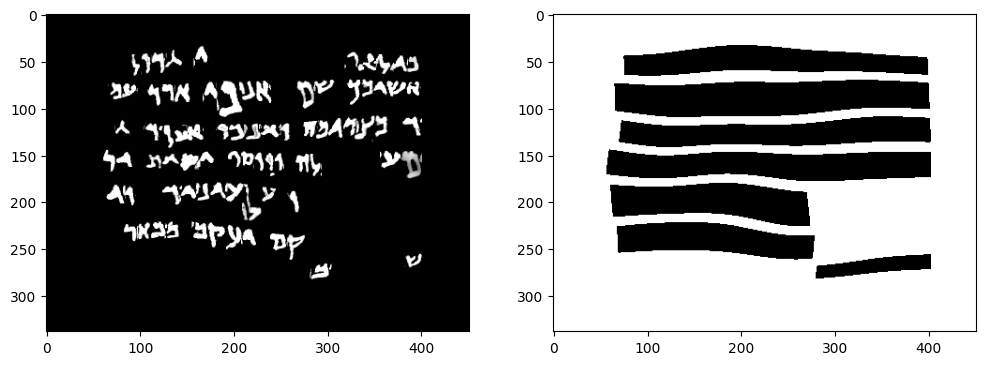

In [196]:
i = 2
img = np.copy(scrolls[2])
line = np.copy(lines[i])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(img, cmap="binary")
ax[1].imshow(line, cmap="binary")




In [ ]:
import os
import random
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Assume DataGenerator and SynthSettings are available from your synthetic pipeline
import sys
sys.path.append("..")

from synthetic import DataGenerator, SynthSettings

class UnpairedImageDataset(Dataset):
    """
    Dataset for unpaired images from two domains:
    - Domain A: synthetic scrolls generated on-the-fly via DataGenerator
    - Domain B: real scroll images loaded from disk
    """
    def __init__(
        self,
        synthetic_generator: DataGenerator,
        num_synthetic: int,
        root_real: str,
        img_size: tuple = (120, 300),
        transform=None
    ):
        tokens, _, scrolls, _ = synthetic_generator.generate_passages_scrolls(
            N=num_synthetic,
            skip_char_seg=True
        )
        self.synthetic_images = [Image.fromarray((arr *).astype(np.uint8)) for arr in scrolls]
        self.real_paths = sorted([
            os.path.join(root_real, f)
            for f in os.listdir(root_real)
            if f.lower().endswith(('zed.jpg'))
        ])
        self.transform = transform or transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            # transforms.Lambda(lambda x: 1.0 - x),
            # transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return max(len(self.synthetic_images), len(self.real_paths))

    def __getitem__(self, idx):
        img_A = self.synthetic_images[idx % len(self.synthetic_images)]
        path_B = random.choice(self.real_paths)
        img_B = Image.open(path_B).convert('L')
        img_A = self.transform(img_A)
        img_B = self.transform(img_B)
        return img_A, img_B


def create_unpaired_dataloader(
    synthetic_generator: DataGenerator,
    num_synthetic: int,
    root_real: str,
    img_size: tuple = (120, 300),
    batch_size: int = 16
) -> DataLoader:
    dataset = UnpairedImageDataset(
        synthetic_generator=synthetic_generator,
        num_synthetic=num_synthetic,
        root_real=root_real,
        img_size=img_size
    )
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True
    )


import os
# from ganv2.cyclegan_dataset import create_unpaired_dataloader
# from ganv2.cyclegan_models import ResnetGenerator, NLayerDiscriminator
from synthetic import DataGenerator, SynthSettings
import matplotlib.pyplot as plt


MAX_SEQ_LEN = 100
gen = DataGenerator(settings=SynthSettings(downscale_factor=0.3))

num_synthetic = 2
root_real     = '../data/image-data'
output_dir    = 'checkpoints/cyclegan'
img_size           = (120, 300)
batch_size         = 16
epochs             = 100





# DataLoader
dataloader = create_unpaired_dataloader(
    synthetic_generator=gen,
    num_synthetic=num_synthetic,
    root_real=root_real,
    img_size=img_size,
    batch_size=batch_size
)

for img_A, img_B in dataloader:
    plt.imshow(img_A[0].squeeze(0).cpu().numpy(), cmap='gray')



TypeError: Unexpected type <class 'numpy.ndarray'>

In [5]:
_, _, scrolls, _ = gen.generate_passages_scrolls(1)

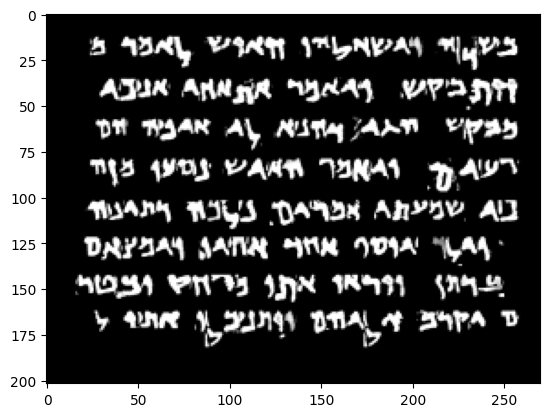

In [7]:
plt.imshow(scrolls[0], cmap="binary")

In [25]:
import pandas as pd
from pathlib import Path

def alphabet_path(cropped: bool = True):
    return Path(".").resolve().parent / "data" / ("alphabet_cropped" if cropped else "alphabet")

def load_n_grams():
    df = pd.read_csv(alphabet_path().parent / "ngrams" / "ngrams_frequencies_withNames.csv")
    df["Names"] = df["Names"].str.replace("Tasdi-final", "Tsadi-final")
    df["Names"] = df["Names"].str.replace(r'Tsadi(?!-final)', "Tsadi-medial", regex=True)

    # ngrams = []
    # for names in df["Names"]:
    #     list_names = names.split("_")
    #     ngrams.append(tuple(str_to_enum[name] for name in list_names))

    # frequencies = df["Frequencies"].to_numpy()
    # ngram_tokens = np.arange(len(ngrams))

    return df


load_n_grams()

,Hebrew_character,Names,Frequencies
0,אל,Alef_Lamed,800
1,כול,Kaf_Waw_Lamed,788
2,אשר,Alef_Shin_Resh,780
3,על,Ayin_Lamed,710
4,את,Alef_Taw,688
...,...,...,...
6055,ויטמאו,Waw_Yod_Tet_Mem-medial_Alef_Waw,2
6056,מקרה,Mem-medial_Qof_Resh_He,2
6057,פלאך,Pe_Lamed_Alef_Kaf-final,2
6058,באמר,Bet_Alef_Mem-medial_Resh,2


In [28]:
tuple(reversed((1, 2)))

(2, 1)

In [22]:
import torch.nn.functional as F
import torch
import torch.nn as nn


block = nn.Sequential(
        nn.Conv2d(1, 3, kernel_size=(5, 15), padding=(2, 6), stride=(1, 4)),
        nn.LeakyReLU()
    )

s = torch.tensor(scrolls, dtype=torch.float).unsqueeze(1)
print(s.shape)
block(s).shape

torch.Size([10, 1, 338, 451])


torch.Size([10, 3, 338, 113])

In [19]:
451 / 151

2.986754966887417

In [8]:
import torch

H = 3
W = 3
C_in = 2
r = 2
C_out = 1
N = 1

x = torch.arange(H * W * C_in * N).view((N, C_in, H, W))
print(x)

x = x.view(N, C_out, r, H, W)

print(x)

dim_to_upscale = "W"

if dim_to_upscale == "H":
    # Target: (N, C_out, H*r, W)
    x = x.permute(0, 1, 3, 2, 4).contiguous() # (N, C_out, H, r, W)
    x = x.view(N, C_out, H * r, W)
elif dim_to_upscale == "W":
    # Target: (N, C_out, H, W*r)
    x = x.permute(0, 1, 3, 4, 2).contiguous() # (N, C_out, H, W, r)
    x = x.view(N, C_out, H, W * r)


print(x)


tensor([[[[ 0,  1,  2],
          [ 3,  4,  5],
          [ 6,  7,  8]],

         [[ 9, 10, 11],
          [12, 13, 14],
          [15, 16, 17]]]])
tensor([[[[[ 0,  1,  2],
           [ 3,  4,  5],
           [ 6,  7,  8]],

          [[ 9, 10, 11],
           [12, 13, 14],
           [15, 16, 17]]]]])
tensor([[[[ 0,  9,  1, 10,  2, 11],
          [ 3, 12,  4, 13,  5, 14],
          [ 6, 15,  7, 16,  8, 17]]]])


In [30]:
from alphabet import A

hebrew_to_enum = {
    'א': A.Alef,
    'ע': A.Ayin,
    'ב': A.Bet,
    'ד': A.Dalet,
    'ג': A.Gimel,
    'ה': A.He,
    'ח': A.Het,
    'כ': A.Kaf,
    'ך': A.Kaf_final,
    'ל': A.Lamed,
    'ם': A.Mem,
    'מ': A.Mem_medial,
    'ן': A.Nun_final,
    'נ': A.Nun_medial,
    'פ': A.Pe,
    'ף': A.Pe_final,
    'ק': A.Qof,
    'ר': A.Resh,
    'ס': A.Samekh,
    'ש': A.Shin,
    'ת': A.Taw,
    'ט': A.Tet,
    'ץ': A.Tsadi_final,
    'צ': A.Tsadi_medial,
    'ו': A.Waw,
    'י': A.Yod,
    'ז': A.Zayin
}


inv = {v: k for k, v in hebrew_to_enum.items()}

with open("./test.txt", "w", encoding="utf-8") as f:

    f.write(inv[A.Alef] + inv[A.Ayin] + inv[A.Bet] + "\n" + inv[A.Dalet])


In [12]:
import pickle
import numpy as np

z = np.load("../data/scrolls_seg/level_0/chunk_0.npz")
s = z["segmentation"]

In [ ]:
s.nbytes / 1_000_000

2057.913

: 

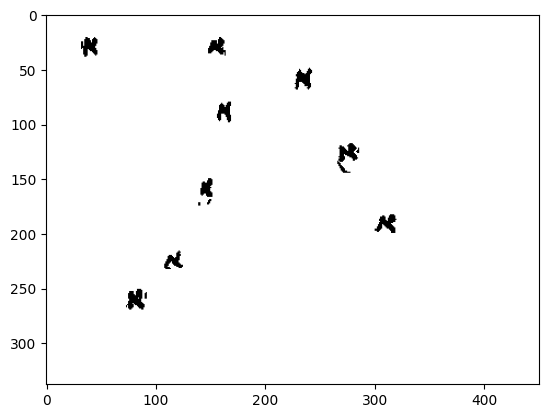

In [8]:
from matplotlib import pyplot as plt

plt.imshow(s[3, 0], cmap="binary")